## import & utils


In [52]:
from collections import namedtuple
from functools import partial
import numpy as np
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
from types import SimpleNamespace as Bunch
from IPython.display import clear_output, Image
import plotly.graph_objects as go
from ipywidgets import interact
from tqdm.auto import tqdm, trange
import jraph

pl.style.use("dark_background")


def np2pil(a):
    a = np.asarray(a)
    if a.dtype.kind == "f":
        a = np.uint8(a.clip(0, 1) * 255)
    return PIL.Image.fromarray(a)


def imshow(a):
    display(np2pil(a))


def zoom(a, k=2):
    return np.repeat(np.repeat(a, k, 1), k, 0)


def tile2d(a, w=None):
    a = np.asarray(a)
    if w is None:
        w = int(np.ceil(np.sqrt(len(a))))
    th, tw = a.shape[1:3]
    pad = (w - len(a)) % w
    a = np.pad(a, [(0, pad)] + [(0, 0)] * (a.ndim - 1), "constant")
    h = len(a) // w
    a = a.reshape([h, w] + list(a.shape[1:]))
    a = np.rollaxis(a, 2, 1).reshape([th * h, tw * w] + list(a.shape[4:]))
    return a

In [53]:
2**8

256

In [54]:
import jax
import jax.numpy as jp
import optax
from flax import nnx

In [55]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Params

In [58]:
from model import generate_layer_sizes

In [66]:
input_n, output_n = 4, 4
arity = 2
layer_sizes = generate_layer_sizes(input_n, output_n, arity, layer_n=3)
loss_type = "l4"

In [70]:
layer_sizes

[(4, 1), (16, 2), (16, 2), (8, 1), (4, 1)]

## Training


### BackProp

In [71]:
from model import gen_circuit, run_circuit, run_layer
from training import TrainState, train_step, unpack
from viz import evaluate_and_visualize, visualize_network
from tasks import get_task_data, TASKS

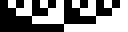

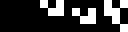

In [75]:
key = jax.random.PRNGKey(42)
wires, logitsbp = gen_circuit(key, layer_sizes, arity=arity)

opt = optax.adamw(1, 0.8, 0.8, weight_decay=1e-1)
state = TrainState(params=logitsbp, opt_state=opt.init(logitsbp))


case_n = 1 << input_n
x = jp.arange(case_n)
x, y0 = get_task_data(
    "binary_multiply", case_n, input_bits=input_n, output_bits=output_n
)

zoom_factor = 8
imshow(zoom(x.T, zoom_factor))
imshow(zoom(y0.T, zoom_factor))

In [76]:
loss_log_bp = []
aux_log_bp = []

In [77]:
pbar = trange(100)
for i in pbar:
    loss, aux, state = train_step(state, opt, wires, x, y0, loss_type, do_train=True)
    loss_log_bp.append(loss)
    aux_log_bp.append(aux)
    pbar.set_postfix_str(
        f"loss: {loss.item():.3E}, accuracy: {aux['accuracy'].item():.2%}"
        + (
            f" | hard_loss: {aux['hard_loss'].item():.3E}, hard_accuracy: {aux['hard_accuracy'].item():.2%}"
            if "hard_loss" in aux
            else ""
        )
    )

  0%|          | 0/100 [00:00<?, ?it/s]

In [78]:
%timeit train_step(state, opt, wires, x, y0, loss_type, do_train=True)

4.39 ms ± 162 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


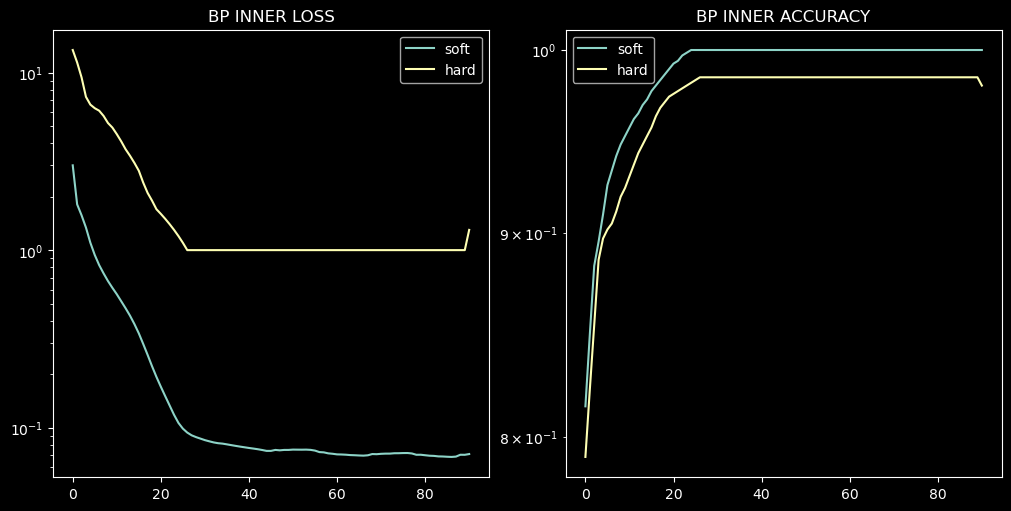

In [96]:
def plot_losses(
    loss_log, aux_log, figax=None, title=None, plot_accuracy=False, plot_hard=True
):
    if figax is None:
        fig, ax = plt.subplots()
    else:
        fig, ax = figax
    v = len(loss_log) // 10

    if not plot_accuracy:
        smooth_losses = np.convolve(loss_log, np.ones(v) / v, mode="valid")
        hard_losses = [aux["hard_loss"] for aux in aux_log]
        smooth_hard_losses = np.convolve(hard_losses, np.ones(v) / v, mode="valid")
        ax.plot(smooth_losses, label="soft")
        if plot_hard:
            ax.plot(jp.maximum(smooth_hard_losses, 1e-5), label="hard")
    else:
        accs = [aux["accuracy"] for aux in aux_log]
        smooth_accs = np.convolve(accs, np.ones(v) / v, mode="valid")
        ax.plot(smooth_accs, label="soft")
        hard_accs = [aux["hard_accuracy"] for aux in aux_log]
        smooth_hard_accs = np.convolve(hard_accs, np.ones(v) / v, mode="valid")
        if plot_hard:
            ax.plot(smooth_hard_accs, label="hard")

    ax.legend()
    ax.set_yscale("log")

    if title is not None:
        ax.set_title(title)


fig, axs = plt.subplots(
    1, 2, figsize=(10, 5), sharey=False, sharex=True, constrained_layout=True
)
plot_losses(loss_log_bp, aux_log_bp, (fig, axs[0]), title="BP INNER LOSS")
plot_losses(
    loss_log_bp,
    aux_log_bp,
    (fig, axs[1]),
    plot_accuracy=True,
    title="BP INNER ACCURACY",
)

In [111]:
bp_results = {
    "losses": loss_log_bp,
    "aux_log": aux_log_bp,
}

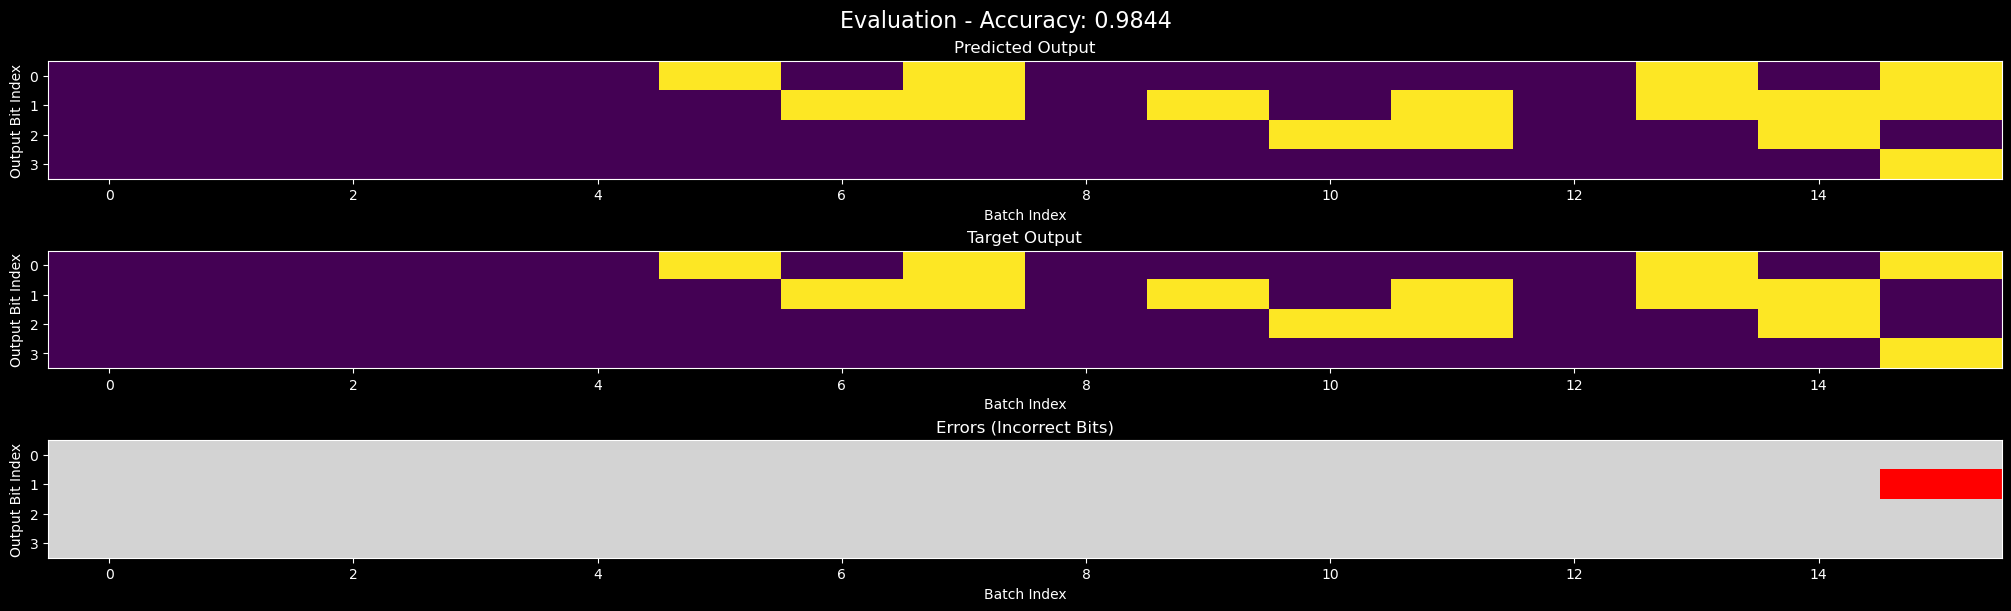

In [80]:
metrics = evaluate_and_visualize(state.params, wires, x, y0, hard=True)

### GNN

In [51]:
from graph import train_gnn, build_graph, CircuitGNN, extract_logits_from_graph
from training import loss_f_l4

In [62]:
hidden_dim = 64
hidden_features = 64
n_message_steps = 25
graph = build_graph(logitsbp, wires, input_n, arity, hidden_dim=hidden_dim)
gnn = CircuitGNN(
    hidden_dim=hidden_dim,
    message_passing=True,
    node_mlp_features=[hidden_features, hidden_features],
    edge_mlp_features=[hidden_features, hidden_features],
    rngs=nnx.Rngs(params=jax.random.PRNGKey(42)),
    use_attention=True,
)
opt_fn = optax.adamw(1, 0.8, 0.8, weight_decay=1e-1)
opt = nnx.Optimizer(gnn, opt_fn)

In [66]:
def loss_fn(gnn_model: CircuitGNN, graph: jraph.GraphsTuple):
    updated_graph = gnn_model(graph)
    updated_logits = extract_logits_from_graph(
        updated_graph, tuple([logit.shape for logit in logitsbp])
    )
    return loss_f_l4(updated_logits, wires, x, y0)


loss, grads = nnx.value_and_grad(loss_fn, has_aux=True)(gnn, graph)

In [67]:
opt.update(grads)

In [68]:
grads

State({
  'aggregate_fn': {
    'key_proj': {
      'bias': VariableState(
        type=Param,
        value=Array([ 1.4210855e-14,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
                1.4210855e-14,  0.0000000e+00,  1.1368684e-13,  1.1368684e-13,
                1.1368684e-13, -1.5987212e-14,  0.0000000e+00, -5.3290705e-15,
                0.0000000e+00, -5.6843419e-14,  5.6843419e-14,  0.0000000e+00,
                1.4210855e-14,  0.0000000e+00, -5.6843419e-14,  1.1368684e-13,
                1.1368684e-13,  0.0000000e+00,  0.0000000e+00,  1.1368684e-13,
                0.0000000e+00,  0.0000000e+00,  7.1054274e-15,  0.0000000e+00,
                0.0000000e+00,  0.0000000e+00, -5.6843419e-14,  0.0000000e+00,
                5.6843419e-14,  0.0000000e+00,  2.8421709e-14,  5.6843419e-14,
                1.4210855e-14,  0.0000000e+00, -1.1368684e-13,  0.0000000e+00,
                2.8421709e-14,  5.6843419e-14,  5.6843419e-14, -2.1316282e-14,
                1.1368684e-13,

In [ ]:
gnn_results = train_gnn(
    layer_sizes=layer_sizes,
    x_data=x,
    y_data=y0,
    arity=arity,
    hidden_dim=hidden_dim,
    message_passing=True,
    node_mlp_features=[hidden_features, hidden_features],
    edge_mlp_features=[hidden_features, hidden_features],
    learning_rate=1e-4,
    epochs=2**15,
    n_message_steps=n_message_steps,
    key=42,
    weight_decay=1e-5,
    meta_learning=True,
    meta_batch_size=64,
    check_gradients=True,
    lr_scheduler="cosine",
    use_attention=True,
)

Training GNN:   0%|          | 0/32768 [00:00<?, ?it/s]

In [131]:
# recreate aux in old format
aux_log = [
    {
        "accuracy": accuracies,
        "hard_accuracy": hard_acc,
        "hard_loss": hard_loss,
    }
    for accuracies, hard_acc, hard_loss in zip(
        gnn_results["accuracies"],
        gnn_results["hard_accuracies"],
        gnn_results["hard_losses"],
    )
]

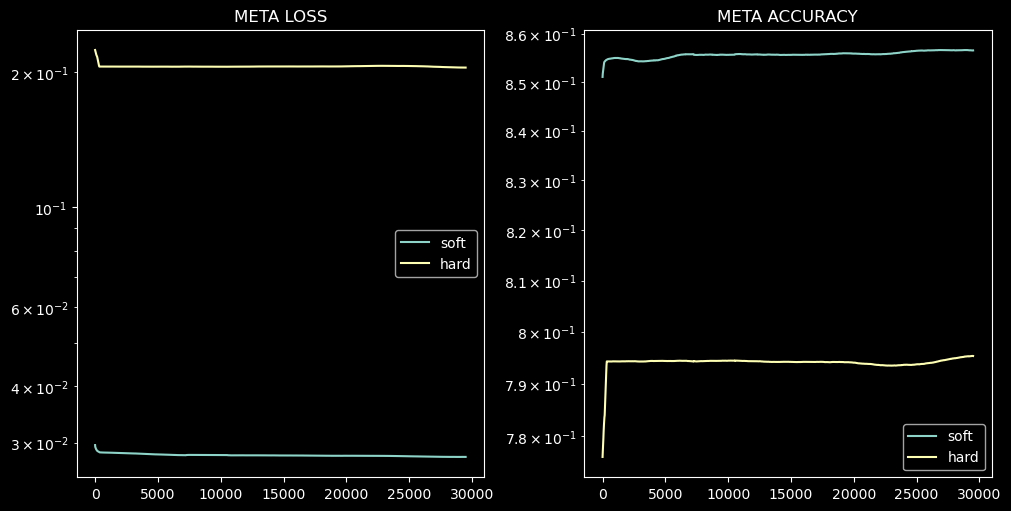

In [132]:
fig, axs = plt.subplots(
    1, 2, figsize=(10, 5), sharey=False, sharex=True, constrained_layout=True
)
plot_losses(
    gnn_results["losses"], aux_log, (fig, axs[0]), title="META LOSS", plot_hard=True
)
plot_losses(
    gnn_results["losses"],
    aux_log,
    (fig, axs[1]),
    plot_accuracy=True,
    title="META ACCURACY",
    plot_hard=True,
)

In [133]:
# Get the inner loop losses

from graph import evaluate_gnn_stepwise

In [134]:
gnn_results.keys()

dict_keys(['gnn', 'optimizer', 'losses', 'hard_losses', 'accuracies', 'hard_accuracies', 'learning_rates'])

In [135]:
key = jax.random.PRNGKey(42)
wires_gnn, logits_gnn = gen_circuit(key, layer_sizes, arity=arity)
step_metrics = evaluate_gnn_stepwise(
    gnn_results["gnn"],
    wires_gnn,
    logits_gnn,
    x,
    y0,
    input_n,
    n_message_steps=n_message_steps,
    arity=arity,
    hidden_dim=hidden_dim,
)

Evaluating GNN steps:   0%|          | 0/100 [00:00<?, ?it/s]

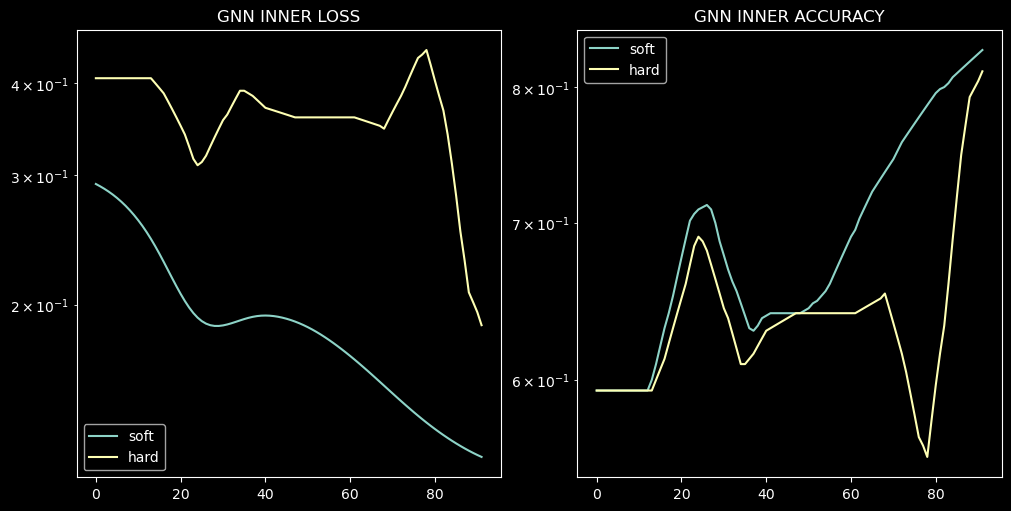

In [136]:
aux_log = [
    {
        "accuracy": accuracies,
        "hard_accuracy": hard_acc,
        "hard_loss": hard_loss,
    }
    for accuracies, hard_acc, hard_loss in zip(
        step_metrics["soft_accuracy"],
        step_metrics["hard_accuracy"],
        step_metrics["hard_loss"],
    )
]

fig, ax = plt.subplots(
    1, 2, figsize=(10, 5), sharey=False, sharex=True, constrained_layout=True
)
plot_losses(
    step_metrics["soft_loss"],
    aux_log,
    plot_accuracy=False,
    figax=(fig, ax[0]),
    title="GNN INNER LOSS",
)
plot_losses(
    step_metrics["soft_loss"],
    aux_log,
    plot_accuracy=True,
    figax=(fig, ax[1]),
    title="GNN INNER ACCURACY",
)

In [137]:
gnn_log_results = {
    "losses": step_metrics["soft_loss"],
    "aux_log": aux_log,
}

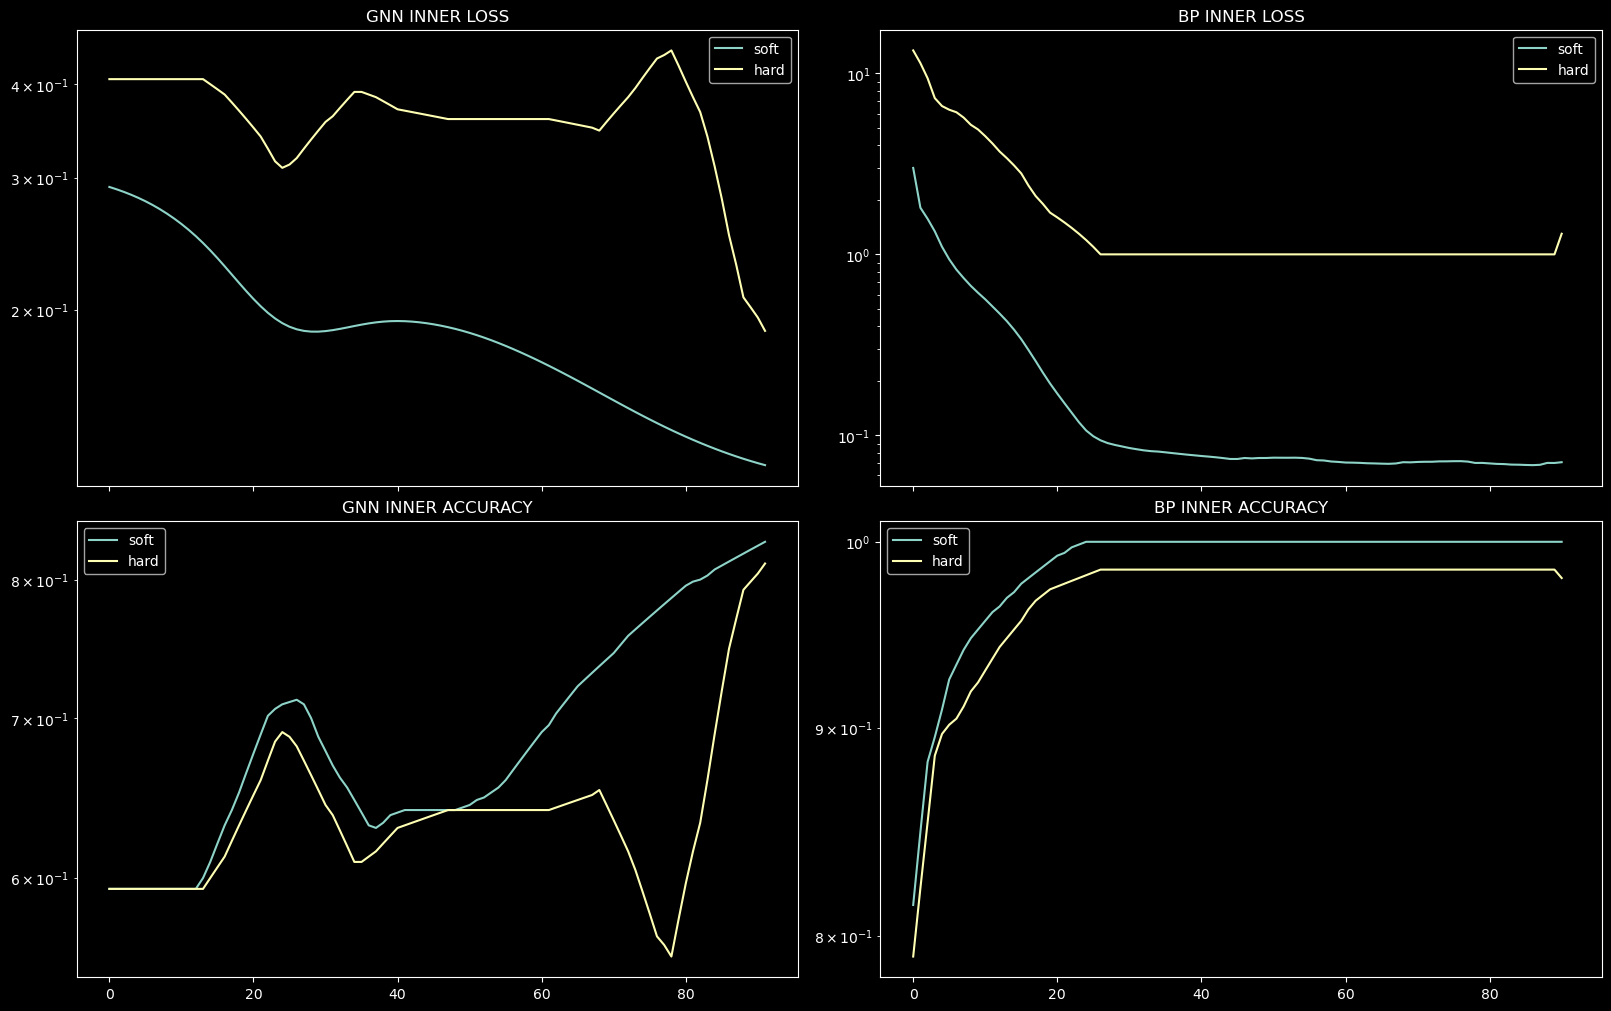

In [138]:
# Compare GNN and BP

fig, axs = plt.subplots(
    2, 2, figsize=(16, 10), sharey=False, sharex=True, constrained_layout=True
)

for method, axs_method, results in zip(
    ["GNN", "BP"], axs.T, [gnn_log_results, bp_results]
):
    for metric, ax in zip(["loss", "accuracy"], axs_method):
        if metric == "loss":
            plot_losses(
                results["losses"],
                results["aux_log"],
                (fig, ax),
                title=f"{method} INNER LOSS",
            )
        else:
            plot_losses(
                results["losses"],
                results["aux_log"],
                (fig, ax),
                title=f"{method} INNER ACCURACY",
                plot_accuracy=True,
            )